In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [10]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [12]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [13]:
len(dataset)

68

In [14]:
68*32

2176

In [15]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())
    print(img_batch[0])

(32, 256, 256, 3)
[0 0 2 0 0 0 0 0 2 0 0 2 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1]
tf.Tensor(
[[[ 64.  70.  94.]
  [123. 129. 153.]
  [113. 119. 143.]
  ...
  [139. 145. 169.]
  [138. 144. 168.]
  [136. 142. 166.]]

 [[ 92.  98. 122.]
  [ 90.  96. 120.]
  [ 69.  75.  99.]
  ...
  [137. 143. 167.]
  [135. 141. 165.]
  [134. 140. 164.]]

 [[ 80.  86. 110.]
  [ 64.  70.  94.]
  [ 69.  75.  99.]
  ...
  [137. 143. 167.]
  [135. 141. 165.]
  [133. 139. 163.]]

 ...

 [[ 80.  89. 118.]
  [ 92. 101. 130.]
  [ 98. 107. 136.]
  ...
  [137. 150. 182.]
  [139. 152. 184.]
  [140. 153. 185.]]

 [[104. 113. 142.]
  [ 60.  69.  98.]
  [ 66.  75. 104.]
  ...
  [136. 149. 181.]
  [137. 150. 182.]
  [137. 150. 182.]]

 [[ 82.  91. 120.]
  [106. 115. 144.]
  [102. 111. 140.]
  ...
  [140. 153. 185.]
  [139. 152. 184.]
  [138. 151. 183.]]], shape=(256, 256, 3), dtype=float32)


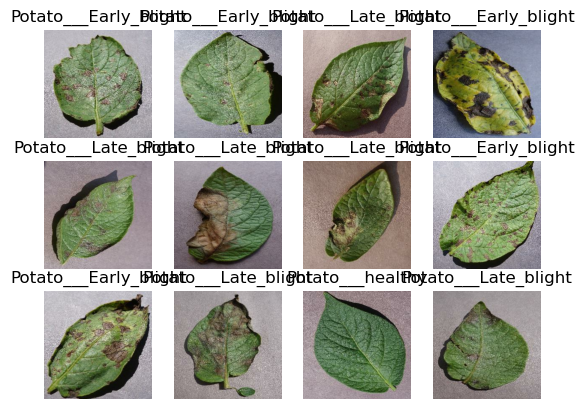

In [16]:
for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [17]:
#  in this we divide the dataset into training, validation and test
#  in the ratio of 80:10:10

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [18]:
train_ds = dataset.take(54)
len(train_ds)

54

In [20]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [21]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [22]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [23]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [34]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(ds_size*train_split)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [35]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [36]:
len(train_ds)

54

In [37]:
len(val_ds)

6

In [38]:
len(test_ds)

8